# Module import

In [1]:
import joblib
import numpy as np
import pandas as pd
import gc
import time
import os
import sys
from contextlib import contextmanager
from lightgbm import LGBMClassifier
import lightgbm as lgb
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, roc_curve, f1_score
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, cross_val_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
# from bayes_opt import BayesianOptimization
# from skopt import BayesSearchCV 
from optbinning import OptimalBinning
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
# from yellowbrick.cluster import KElbowVisualizer
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from sklearn.decomposition import PCA
from functools import reduce
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from tqdm.auto import tqdm
import random
import warnings
# warnings.simplefilter(action='ignore', category=FutureWarning)

# warnings 끄기
warnings.filterwarnings('ignore')

(CVXPY) Feb 20 07:18:22 PM: Encountered unexpected exception importing solver GLOP:
RuntimeError('Unrecognized new version of ortools (9.5.2237). Expected < 9.5.0.Please open a feature request on cvxpy to enable support for this version.')
(CVXPY) Feb 20 07:18:22 PM: Encountered unexpected exception importing solver PDLP:
RuntimeError('Unrecognized new version of ortools (9.5.2237). Expected < 9.5.0.Please open a feature request on cvxpy to enable support for this version.')


C:\Users\smcho\AppData\Roaming\Python\Python37\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
pd.set_option('display.max_rows', 500)  # 판다스 데이터프레임의 최대 출력 행수를 500으로 조정

In [3]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(1)

In [4]:
# read data
train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')
sample_submission = pd.read_csv('./data/sample_submission.csv')
original_columns = test.columns.tolist()  # test data의 column을 original로 지정

In [5]:
# test데이터셋에 있는 변수만 선택 
train = train[test.columns.to_list()+['Y_LABEL','SAMPLE_TRANSFER_DAY']].copy()

# EDA

## column 종류 확인

0. ID : 부여번호
1. COMPONENT_ARBITRARY  : 샘플 오일 관련 부품 (Component 4종, 비식별화)
---
2. ANONYMOUS_1 : 무명 Feautre 1. 수치형 데이터
3. ANONYMOUS_2 : 무명 Feautre 2. 수치형 데이터
---
4. YEAR : 오일 샘플 및 진단 해 (Year)
---
5. AG : 원소기호 AG - Silver 함유량 (단위 : ppm)
6. CO : 원소기호 CO - Cobolt 함유량 (단위 : ppm)
7. CR : 원소기호 CR - Chromium 함유량 (단위 : ppm)
8. CU : 원소기호 CU - Copper 함유량 (단위 : ppm)
9. FE : 원소기호 FE - Iron 함유량 (단위 : ppm)
10. H2O : Water 함유량 (단위 : ppm)
11. MN : 원소기호 MN - Manganese 함유량 (단위 : ppm)
12. MO : 원소기호 MO - Molybdenum 함유량 (단위 : ppm)
13. NI : 원소기호 NI - Nickel 함유량 (단위 : ppm)
14. PQINDEX : Particle Quantifier Index (단위 : X)
15. TI : 원소기호 TI - Titanium 함유량 (단위 : ppm)
16. V : 원소기호 V - Vanadium 함유량 (단위 : ppm)
17. V40 : Viscosity @ 40 degrees (단위 : cSt)
18. ZN : 원소기호 ZN - Zinc 함유량 (단위 : ppm)
---
19. Y_LABLE : 오일 정상 여부 (0 : 정상, 1 : 이상)
20. SAMPLE_TRANSFER_DAY : 오일 샘플링 후 진단 기관으로 이동한 기간 (Days)

In [6]:
train['Y_LABEL'].unique()

array([0, 1], dtype=int64)

In [7]:
print("Y_LABEL 비율 확인")
print(f"{train.Y_LABEL.value_counts().index[0]} : {round(train.Y_LABEL.value_counts()[0] / len(train), 2)*100}%")
print(f"{train.Y_LABEL.value_counts().index[1]} : {round(train.Y_LABEL.value_counts()[1] / len(train), 2)*100}%")

Y_LABEL 비율 확인
0 : 91.0%
1 : 9.0%


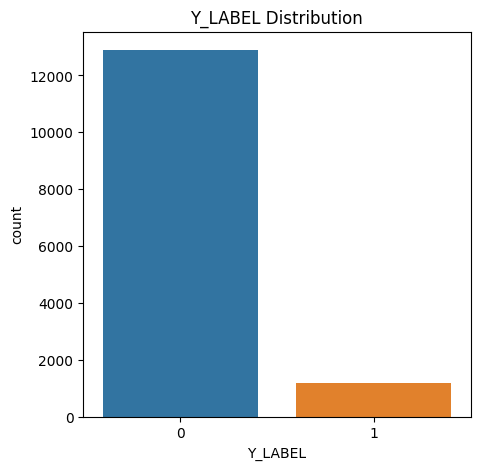

In [8]:
plt.figure(figsize = (5,5))
sns.countplot(x = train['Y_LABEL'])
plt.title('Y_LABEL Distribution')
plt.show()

# 파생변수 생성

## New feature
- 'YEAR' + 'COMPONENT_ARBITRARY'

In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14095 entries, 0 to 14094
Data columns (total 21 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   14095 non-null  object 
 1   COMPONENT_ARBITRARY  14095 non-null  object 
 2   ANONYMOUS_1          14095 non-null  int64  
 3   YEAR                 14095 non-null  int64  
 4   ANONYMOUS_2          14095 non-null  int64  
 5   AG                   14095 non-null  int64  
 6   CO                   14095 non-null  int64  
 7   CR                   14095 non-null  int64  
 8   CU                   14095 non-null  int64  
 9   FE                   14095 non-null  int64  
 10  H2O                  14095 non-null  float64
 11  MN                   14095 non-null  int64  
 12  MO                   14095 non-null  int64  
 13  NI                   14095 non-null  int64  
 14  PQINDEX              14095 non-null  int64  
 15  TI                   14095 non-null 

In [10]:
train[['YEAR', 'COMPONENT_ARBITRARY']]

,YEAR,COMPONENT_ARBITRARY
0,2011,COMPONENT3
1,2021,COMPONENT2
2,2015,COMPONENT2
3,2010,COMPONENT3
4,2015,COMPONENT3
...,...,...
14090,2014,COMPONENT3
14091,2013,COMPONENT1
14092,2008,COMPONENT3
14093,2009,COMPONENT2


In [11]:
"""
new features 
"""

train['YEAR_COMPONENT'] = train[['YEAR','COMPONENT_ARBITRARY']].apply(lambda x: '-'.join(x.astype(str)),axis=1)
test['YEAR_COMPONENT'] = test[['YEAR','COMPONENT_ARBITRARY']].apply(lambda x: '-'.join(x.astype(str)),axis=1)

var = [i for i in test.columns.tolist() if i not in ['ID','COMPONENT_ARBITRARY']] # var : object 데이터를 제외한 나머지 모든 열들
train['zero_cnt'] = train[var].apply(lambda x:(x==0).sum(),axis=1)
test['zero_cnt'] = test[var].apply(lambda x:(x==0).sum(),axis=1)

## Transformation

In [20]:
train[var_li[4]]

0        888
1          2
2          4
3         37
4         71
        ... 
14090     23
14091     12
14092    415
14093     19
14094     10
Name: FE, Length: 14095, dtype: int64

<AxesSubplot:xlabel='FE', ylabel='Density'>

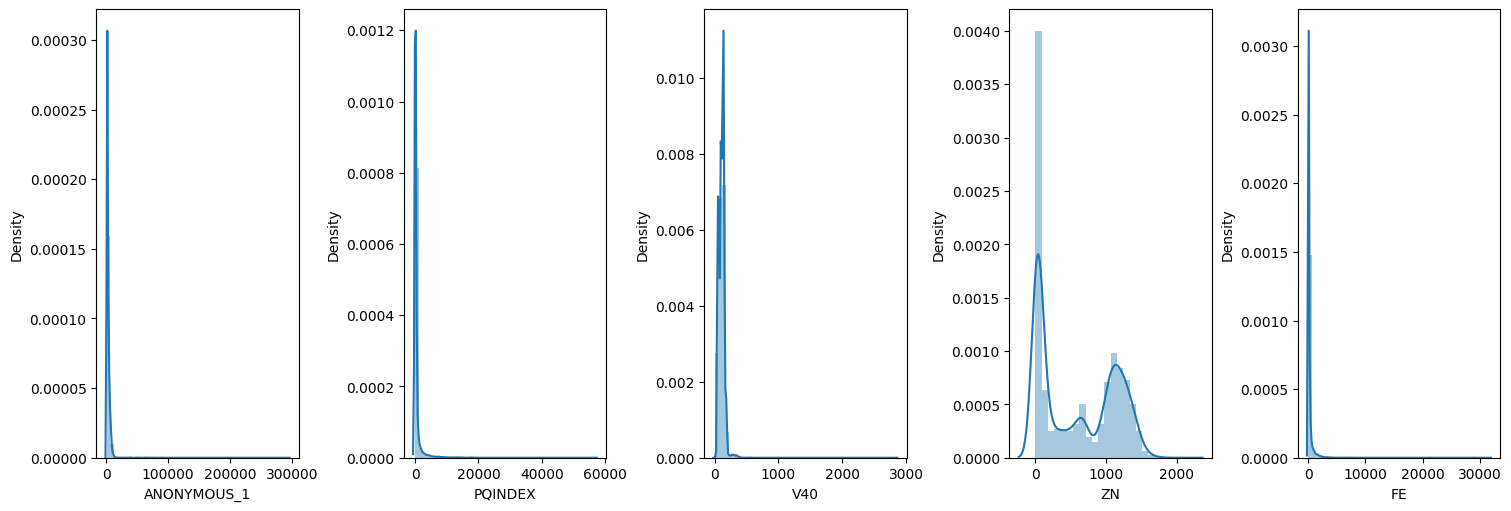

In [43]:
var_li = ['ANONYMOUS_1','PQINDEX','V40','ZN','FE']
fig, ax = plt.subplots(ncols=5,  figsize=(15,5), constrained_layout=True)


sns.distplot(train[var_li[0]], ax=ax[0])
sns.distplot(train[var_li[1]], ax=ax[1])
sns.distplot(train[var_li[2]], ax=ax[2])
sns.distplot(train[var_li[3]], ax=ax[3])
sns.distplot(train[var_li[4]], ax=ax[4])

각 feature의 분포를 확인하자

In [44]:
"""
transformation 
단위수가 맞지 않음
"""

for var in ['ANONYMOUS_1','PQINDEX','V40','ZN','FE']:
            # 무명 feature (수치형 데이터), Particle Quantifier Index, Viscosity @ 40 degrees (단위 : cSt), 
            # 원소기호 ZN - Zinc 함유량 (단위 : ppm), 원소기호 FE - Iron 함유량 (단위 : ppm)
    
    train[var+'_log1'] = np.log(train[var]+1)
    test[var+'_log1'] = np.log(test[var]+1)

데이터가 Skewness하므로 log를 적용하여 Symmetric 하게 변하였음

<AxesSubplot:xlabel='FE_log1', ylabel='Density'>

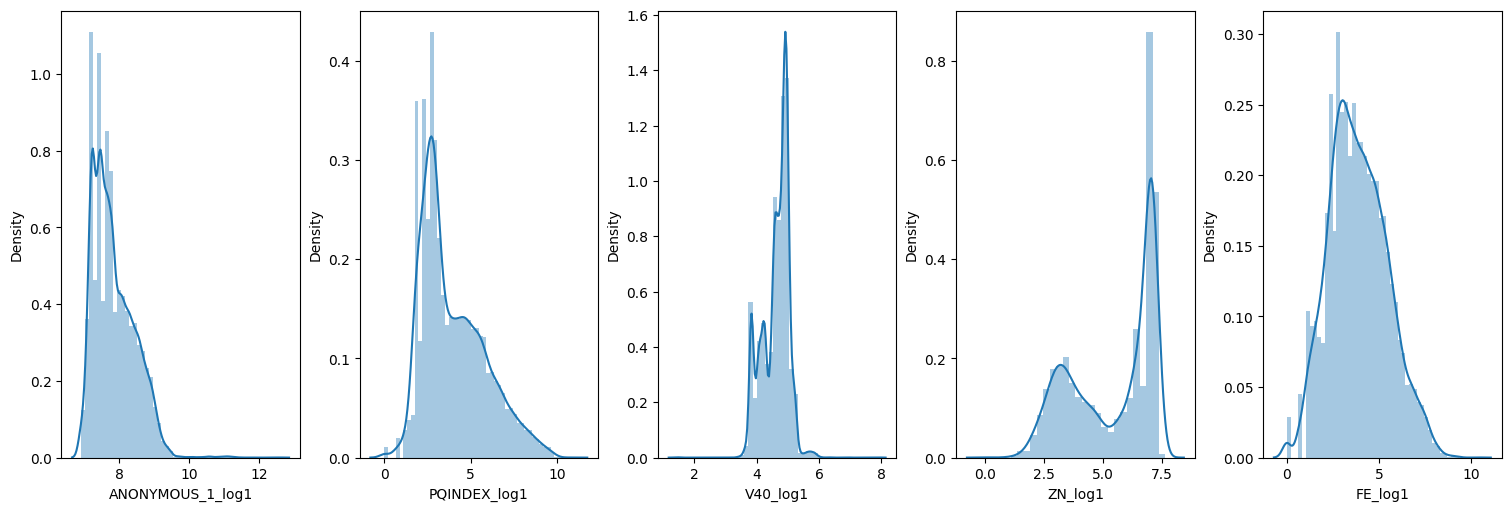

In [46]:
var_li = ['ANONYMOUS_1_log1','PQINDEX_log1','V40_log1','ZN_log1','FE_log1']
fig, ax = plt.subplots(ncols=5,  figsize=(15,5), constrained_layout=True)


sns.distplot(train[var_li[0]], ax=ax[0])
sns.distplot(train[var_li[1]], ax=ax[1])
sns.distplot(train[var_li[2]], ax=ax[2])
sns.distplot(train[var_li[3]], ax=ax[3])
sns.distplot(train[var_li[4]], ax=ax[4])

## Normalization

In [51]:
['ANONYMOUS_1','PQINDEX','V40','ZN','FE']

['ANONYMOUS_1', 'PQINDEX', 'V40', 'ZN', 'FE']

In [52]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14095 entries, 0 to 14094
Data columns (total 28 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   14095 non-null  object 
 1   COMPONENT_ARBITRARY  14095 non-null  object 
 2   ANONYMOUS_1          14095 non-null  int64  
 3   YEAR                 14095 non-null  int64  
 4   ANONYMOUS_2          14095 non-null  int64  
 5   AG                   14095 non-null  int64  
 6   CO                   14095 non-null  int64  
 7   CR                   14095 non-null  int64  
 8   CU                   14095 non-null  int64  
 9   FE                   14095 non-null  int64  
 10  H2O                  14095 non-null  float64
 11  MN                   14095 non-null  int64  
 12  MO                   14095 non-null  int64  
 13  NI                   14095 non-null  int64  
 14  PQINDEX              14095 non-null  int64  
 15  TI                   14095 non-null 

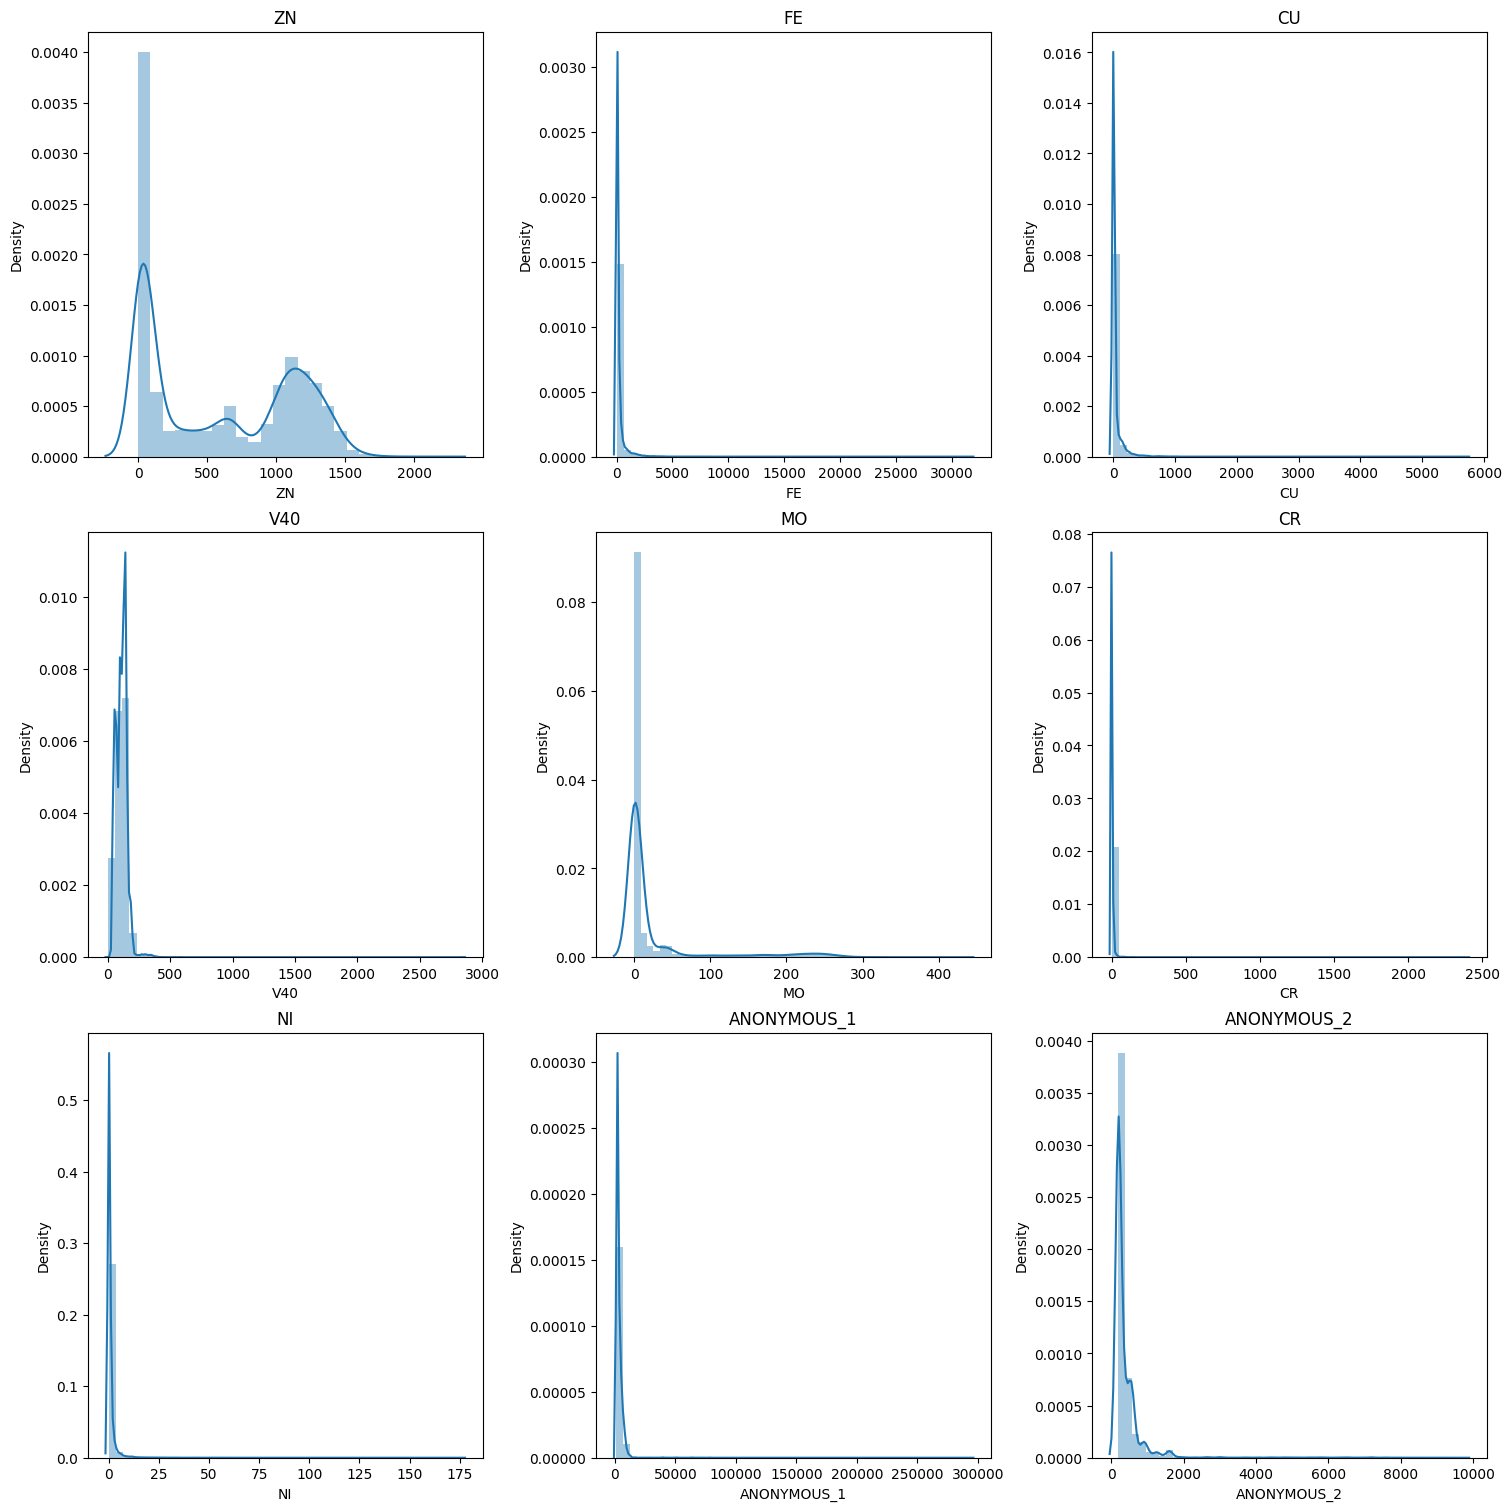

In [50]:
var_li = ['ZN','FE','CU','V40','MO','CR','NI','ANONYMOUS_1','ANONYMOUS_2']

fig, ax = plt.subplots(nrows = 3, ncols=3,  figsize=(15,15), constrained_layout=True)
ax = ax.flatten()

for i in range(len(var_li)):
    sns.distplot(train[var_li[i]], ax=ax[i])
    ax[i].set(title = var_li[i])

이상치가 큰 분포들이 다음과 같이 존재한다.

In [53]:
"""
normalization
""" 

for var in ['ZN','FE','CU','V40','MO','CR','NI','ANONYMOUS_1','ANONYMOUS_2']:
    
    ZN_min = train[var].min()
    ZN_max = train[var].max()
    train[var] = (train[var] - ZN_min) / (ZN_max-ZN_min)
    test[var] = (test[var] - ZN_min) / (ZN_max-ZN_min)

In [55]:
train[var_li]

,ZN,FE,CU,V40,MO,CR,NI,ANONYMOUS_1,ANONYMOUS_2
0,0.035178,0.028007,0.013682,0.053249,0.002387,0.005421,0.034091,0.001656,0.000000
1,0.305816,0.000063,0.005438,0.014484,0.000000,0.000000,0.000000,0.001193,0.018519
2,0.193246,0.000126,0.000351,0.024563,0.000000,0.000417,0.000000,0.004822,0.000000
3,0.003283,0.001167,0.000175,0.045954,0.000000,0.000000,0.000000,0.021772,0.000000
4,0.060038,0.002239,0.000000,0.045884,0.000000,0.000000,0.000000,0.010066,0.000000
...,...,...,...,...,...,...,...,...,...
14090,0.007505,0.000725,0.000526,0.046694,0.000000,0.000000,0.000000,0.002099,0.000000
14091,0.660413,0.000378,0.000351,0.040386,0.534606,0.000000,0.000000,0.006079,0.000000
14092,0.610225,0.013089,0.001228,0.018008,0.023866,0.001668,0.005682,0.002685,0.037037
14093,0.305816,0.000599,0.029819,0.014590,0.002387,0.000000,0.000000,0.005105,0.037037


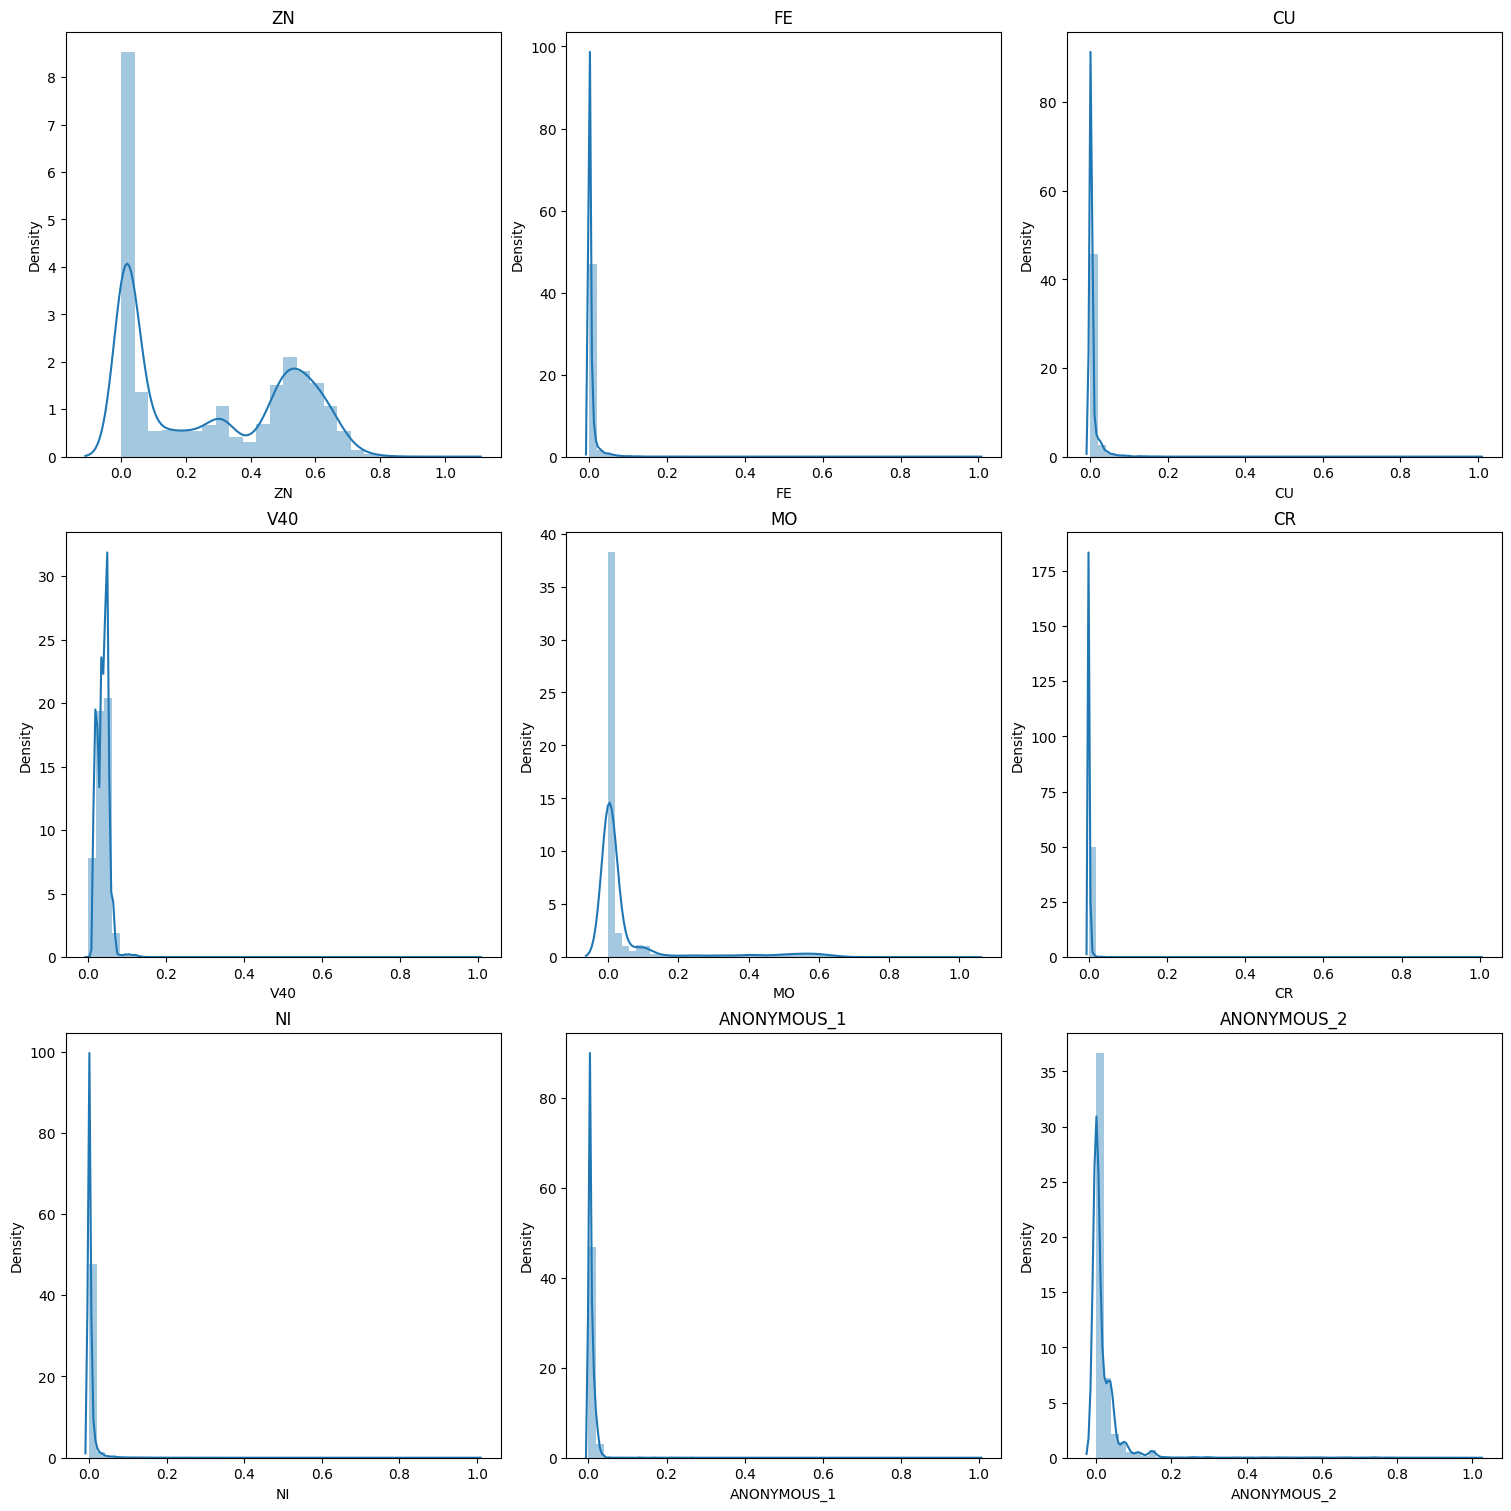

In [54]:
var_li = ['ZN','FE','CU','V40','MO','CR','NI','ANONYMOUS_1','ANONYMOUS_2']

fig, ax = plt.subplots(nrows = 3, ncols=3,  figsize=(15,15), constrained_layout=True)
ax = ax.flatten()

for i in range(len(var_li)):
    sns.distplot(train[var_li[i]], ax=ax[i])
    ax[i].set(title = var_li[i])

min-max normalization을 적용해주니 x값이 0부터 1로 되었다.

## Feature combination

위에서 정규화를 해준 변수들에 대해 곱셈을 하여 새로운 feature를 생성한다.


이와 같이 새로운 feature를 추가하여 모델의 성능을 높일 수 있다.

In [56]:
"""
feature combination
"""

seed_everything(1)

from itertools import chain, product 
candidate_var = ['ZN','FE','CU','V40','MO','CR','NI','ANONYMOUS_1','ANONYMOUS_2']
pairs = list(chain(product(candidate_var, candidate_var), product(candidate_var, candidate_var))) 
pairs = pd.Series([sorted([i,j]) for (i,j) in set(pairs) if i!=j]).drop_duplicates().reset_index(drop=True).tolist()
pairs = sorted(pairs)
# pairs = pairs.sort_values()
# random.shuffle(pairs)
# print(pairs)

for i in range(len(pairs)):
    train[pairs[i][0]+'_'+pairs[i][1]] = train[pairs[i][0]] * train[pairs[i][1]]
    test[pairs[i][0]+'_'+pairs[i][1]] = test[pairs[i][0]] * test[pairs[i][1]] 

In [61]:
train

,ID,COMPONENT_ARBITRARY,ANONYMOUS_1,YEAR,ANONYMOUS_2,AG,CO,CR,CU,FE,...,FE_MO,FE_NI,FE_V40,FE_ZN,MO_NI,MO_V40,MO_ZN,NI_V40,NI_ZN,V40_ZN
0,TRAIN_00000,COMPONENT3,0.001656,2011,0.000000,0,0,0.005421,0.013682,0.028007,...,0.000067,0.000955,1.491368e-03,0.000985,0.000081,0.000127,0.000084,0.001815,0.001199,0.001873
1,TRAIN_00001,COMPONENT2,0.001193,2021,0.018519,0,0,0.000000,0.005438,0.000063,...,0.000000,0.000000,9.136486e-07,0.000019,0.000000,0.000000,0.000000,0.000000,0.000000,0.004429
2,TRAIN_00002,COMPONENT2,0.004822,2015,0.000000,0,0,0.000417,0.000351,0.000126,...,0.000000,0.000000,3.098847e-06,0.000024,0.000000,0.000000,0.000000,0.000000,0.000000,0.004747
3,TRAIN_00003,COMPONENT3,0.021772,2010,0.000000,0,0,0.000000,0.000175,0.001167,...,0.000000,0.000000,5.362739e-05,0.000004,0.000000,0.000000,0.000000,0.000000,0.000000,0.000151
4,TRAIN_00004,COMPONENT3,0.010066,2015,0.000000,0,0,0.000000,0.000000,0.002239,...,0.000000,0.000000,1.027488e-04,0.000134,0.000000,0.000000,0.000000,0.000000,0.000000,0.002755
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14090,TRAIN_14090,COMPONENT3,0.002099,2014,0.000000,0,0,0.000000,0.000526,0.000725,...,0.000000,0.000000,3.387280e-05,0.000005,0.000000,0.000000,0.000000,0.000000,0.000000,0.000350
14091,TRAIN_14091,COMPONENT1,0.006079,2013,0.000000,0,0,0.000000,0.000351,0.000378,...,0.000202,0.000000,1.528527e-05,0.000250,0.000000,0.021591,0.353061,0.000000,0.000000,0.026672
14092,TRAIN_14092,COMPONENT3,0.002685,2008,0.037037,0,0,0.001668,0.001228,0.013089,...,0.000312,0.000074,2.357091e-04,0.007987,0.000136,0.000430,0.014564,0.000102,0.003467,0.010989
14093,TRAIN_14093,COMPONENT2,0.005105,2009,0.037037,0,0,0.000000,0.029819,0.000599,...,0.000001,0.000000,8.743017e-06,0.000183,0.000000,0.000035,0.000730,0.000000,0.000000,0.004462


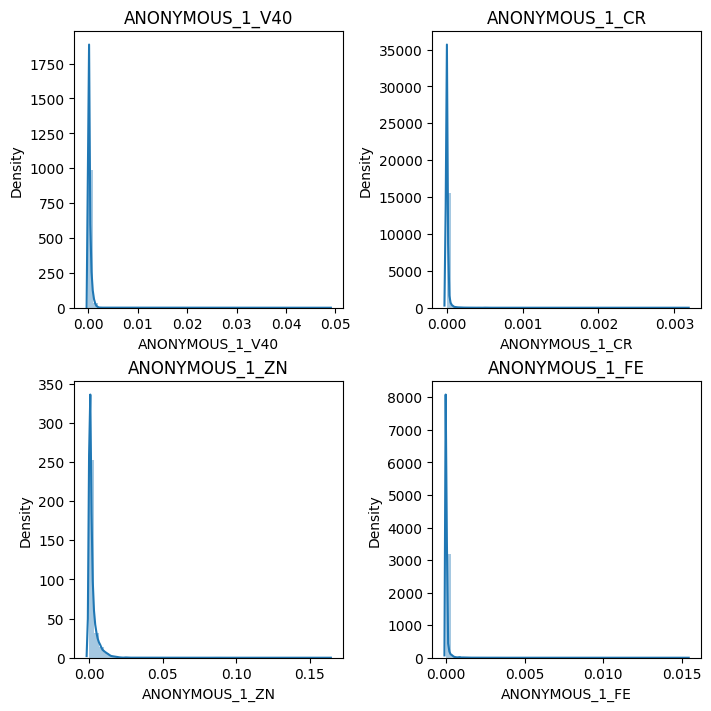

In [64]:
var_li = ['ANONYMOUS_1_V40','ANONYMOUS_1_CR','ANONYMOUS_1_ZN','ANONYMOUS_1_FE']

fig, ax = plt.subplots(nrows = 2, ncols=2,  figsize=(7,7), constrained_layout=True)
ax = ax.flatten()

for i in range(len(var_li)):
    sns.distplot(train[var_li[i]], ax=ax[i])
    ax[i].set(title = var_li[i])

In [67]:
"""
woe features 
"""

for variable in ['ANONYMOUS_1','PQINDEX','V40','ZN','FE']+['ANONYMOUS_1_V40', 'ANONYMOUS_1_CR', 'ANONYMOUS_1_ZN','ANONYMOUS_1_FE']:

    optb = OptimalBinning(name=variable, dtype="numerical", solver="cp")

    x = train[variable].values
    y = train['Y_LABEL']

    optb.fit(x, y)

    binning_table = optb.binning_table

    a1 = binning_table.build()
    
    # check 
    # print('iv:',a1['IV'].sum())
    # display(a1)
    # binning_table.plot(metric="event_rate")

    train[variable+'_woe_bin'] = pd.cut(train[variable],bins=optb.splits.tolist()).astype(str)
    test[variable+'_woe_bin'] = pd.cut(test[variable],bins=optb.splits.tolist()).astype(str)

In [100]:
"""
group operations
"""

opt_numeric_var = ['ANONYMOUS_1_V40', 'ANONYMOUS_1_CR', 'ANONYMOUS_1_ZN','ANONYMOUS_1_FE']

for group in ['COMPONENT_ARBITRARY','YEAR_COMPONENT','YEAR']+['FE_woe_bin']:

    for numeric_var in ['ZN','FE','V40','PQINDEX','CU','ANONYMOUS_1','ANONYMOUS_2']+opt_numeric_var:
        
        train = train.copy()
        test = test.copy()

        a1 = train.groupby([group])[numeric_var].median().to_dict()

        train[numeric_var+'_'+group+'_'+'median'] = train[group].map(a1)
        test[numeric_var+'_'+group+'_'+'median'] = test[group].map(a1)

        train[numeric_var+'_minus_'+numeric_var+'_'+group+'_'+'median'] = train[numeric_var] - train[numeric_var+'_'+group+'_'+'median']
        test[numeric_var+'_minus_'+numeric_var+'_'+group+'_'+'median'] = test[numeric_var] - test[numeric_var+'_'+group+'_'+'median']
        
        train[numeric_var+'_divide_'+numeric_var+'_'+group+'_'+'median'] = np.log(train[numeric_var]+0.00001) / np.log(train[numeric_var+'_'+group+'_'+'median']+0.00001) 
        test[numeric_var+'_divide_'+numeric_var+'_'+group+'_'+'median'] = np.log(test[numeric_var]+0.00001) / np.log(test[numeric_var+'_'+group+'_'+'median']+0.00001)
        
        
        a1 = train.groupby([group])[numeric_var].max().to_dict()

        train[numeric_var+'_'+group+'_'+'max'] = train[group].map(a1)
        test[numeric_var+'_'+group+'_'+'max'] = test[group].map(a1)

        train[numeric_var+'_minus_'+numeric_var+'_'+group+'_'+'max'] = train[numeric_var] - train[numeric_var+'_'+group+'_'+'max']
        test[numeric_var+'_minus_'+numeric_var+'_'+group+'_'+'max'] = test[numeric_var] - test[numeric_var+'_'+group+'_'+'max']
        
        train[numeric_var+'_divide_'+numeric_var+'_'+group+'_'+'max'] = np.log(train[numeric_var]+0.00001) / np.log(train[numeric_var+'_'+group+'_'+'max']+0.00001)
        test[numeric_var+'_divide_'+numeric_var+'_'+group+'_'+'max'] = np.log(test[numeric_var]+0.00001) / np.log(test[numeric_var+'_'+group+'_'+'max']+0.00001)
        
        
        a1 = train.groupby([group])[numeric_var].min().to_dict()

        train[numeric_var+'_'+group+'_'+'min'] = train[group].map(a1)
        test[numeric_var+'_'+group+'_'+'min'] = test[group].map(a1)

        train[numeric_var+'_minus_'+numeric_var+'_'+group+'_'+'min'] = train[numeric_var] - train[numeric_var+'_'+group+'_'+'min']
        test[numeric_var+'_minus_'+numeric_var+'_'+group+'_'+'min'] = test[numeric_var] - test[numeric_var+'_'+group+'_'+'min']
        
        train[numeric_var+'_divide_'+numeric_var+'_'+group+'_'+'min'] = np.log(train[numeric_var]+0.00001) / np.log(train[numeric_var+'_'+group+'_'+'min']+0.00001) 
        test[numeric_var+'_divide_'+numeric_var+'_'+group+'_'+'min'] = np.log(test[numeric_var]+0.00001) / np.log(test[numeric_var+'_'+group+'_'+'min']+0.00001) 
        
        
        a1 = train.groupby([group])[numeric_var].sum().to_dict()

        train[numeric_var+'_'+group+'_'+'sum'] = train[group].map(a1)
        test[numeric_var+'_'+group+'_'+'sum'] = test[group].map(a1)

        train[numeric_var+'_minus_'+numeric_var+'_'+group+'_'+'sum'] = train[numeric_var] - train[numeric_var+'_'+group+'_'+'sum']
        test[numeric_var+'_minus_'+numeric_var+'_'+group+'_'+'sum'] = test[numeric_var] - test[numeric_var+'_'+group+'_'+'sum']
        
        train[numeric_var+'_divide_'+numeric_var+'_'+group+'_'+'sum'] = np.log(train[numeric_var]+0.00001) / np.log(train[numeric_var+'_'+group+'_'+'sum']+0.00001)
        test[numeric_var+'_divide_'+numeric_var+'_'+group+'_'+'sum'] = np.log(test[numeric_var]+0.00001) / np.log(test[numeric_var+'_'+group+'_'+'sum']+0.00001)

In [102]:
train.head()

,ID,COMPONENT_ARBITRARY,ANONYMOUS_1,YEAR,ANONYMOUS_2,AG,CO,CR,CU,FE,...,ANONYMOUS_1_FE_divide_ANONYMOUS_1_FE_FE_woe_bin_median,ANONYMOUS_1_FE_FE_woe_bin_max,ANONYMOUS_1_FE_minus_ANONYMOUS_1_FE_FE_woe_bin_max,ANONYMOUS_1_FE_divide_ANONYMOUS_1_FE_FE_woe_bin_max,ANONYMOUS_1_FE_FE_woe_bin_min,ANONYMOUS_1_FE_minus_ANONYMOUS_1_FE_FE_woe_bin_min,ANONYMOUS_1_FE_divide_ANONYMOUS_1_FE_FE_woe_bin_min,ANONYMOUS_1_FE_FE_woe_bin_sum,ANONYMOUS_1_FE_minus_ANONYMOUS_1_FE_FE_woe_bin_sum,ANONYMOUS_1_FE_divide_ANONYMOUS_1_FE_FE_woe_bin_sum
0,TRAIN_00000,COMPONENT3,0.001656,2011,0.000000,0,0,0.005421,0.013682,0.028007,...,0.855739,0.015339,-0.015292,2.342344,0.0,4.638443e-05,0.849768,0.293968,-0.293921,7.991265
1,TRAIN_00001,COMPONENT2,0.001193,2021,0.018519,0,0,0.000000,0.005438,0.000063,...,1.006371,0.015339,-0.015339,2.754656,0.0,7.523518e-08,0.999349,0.293968,-0.293968,9.397931
2,TRAIN_00002,COMPONENT2,0.004822,2015,0.000000,0,0,0.000417,0.000351,0.000126,...,1.001861,0.015339,-0.015338,2.742312,0.0,6.083302e-07,0.994871,0.293968,-0.293967,9.355816
3,TRAIN_00003,COMPONENT3,0.021772,2010,0.000000,0,0,0.000000,0.000175,0.001167,...,0.931896,0.000417,-0.000391,1.320850,0.0,2.540724e-05,0.890182,0.020968,-0.020943,2.652150
4,TRAIN_00004,COMPONENT3,0.010066,2015,0.000000,0,0,0.000000,0.000000,0.002239,...,0.962734,0.001214,-0.001192,1.540966,0.0,2.254197e-05,0.897511,0.027017,-0.026994,2.861579


In [81]:
"""
clustetring features
"""

np.random.seed(1)

features = ['ZN','FE','V40','CU','MO']

# sc = MinMaxScaler((0, 1))
# sc_fit = sc.fit(train[features])
# train_scaled = sc_fit.transform(train[features])
# kmeans = KMeans(n_clusters=15,n_init=25, max_iter = 600, random_state=1).fit(train_scaled)
# test_scaled = sc_fit.transform(test[features])
# train["cluster_no"] = kmeans.predict(train_scaled)
# test["cluster_no"] = kmeans.predict(test_scaled)

# 앞에서 min-max 이미 적용 함 
kmeans = KMeans(n_clusters=15,n_init=25, max_iter = 600, random_state=1).fit(train[features])
train["cluster_no"] = kmeans.predict(train[features])
test["cluster_no"] = kmeans.predict(test[features])

# check
# print(train['cluster_no'].value_counts())

for var in ['ANONYMOUS_1','ANONYMOUS_2']+['ANONYMOUS_1_V40', 'ANONYMOUS_1_CR', 'ANONYMOUS_1_ZN','ANONYMOUS_1_FE']:
    
    a1 = train.groupby(['cluster_no'])[var].mean().to_dict()
    train['cluster_no_by'+'_'+var+'_'+'mean'] = train['cluster_no'].map(a1)
    test['cluster_no_by'+'_'+var+'_'+'mean'] = test['cluster_no'].map(a1)
    
    a1 = train.groupby(['cluster_no'])[var].median().to_dict()
    train['cluster_no_by'+'_'+var+'_'+'median'] = train['cluster_no'].map(a1)
    test['cluster_no_by'+'_'+var+'_'+'median'] = test['cluster_no'].map(a1)

    a1 = train.groupby(['cluster_no'])[var].max().to_dict()
    train['cluster_no_by'+'_'+var+'_'+'max'] = train['cluster_no'].map(a1)
    test['cluster_no_by'+'_'+var+'_'+'max'] = test['cluster_no'].map(a1)

    a1 = train.groupby(['cluster_no'])[var].min().to_dict()
    train['cluster_no_by'+'_'+var+'_'+'min'] = train['cluster_no'].map(a1)
    test['cluster_no_by'+'_'+var+'_'+'min'] = test['cluster_no'].map(a1)

In [82]:
# check inf values 
a1 = train.select_dtypes(include=['int','float']).apply(lambda x: x.max(),axis=0).reset_index(name='val')
a1.loc[a1['val']==np.Inf,'index'].tolist()

[]

# Model train

In [ ]:
def train_model(train,test,params,stratified,num_folds,drop_features,seed_num):
    
    # start log 
    print('-'*50)
    print('>> seed_num:',seed_num)   
    # print('>> drop_features:',len(drop_features))
    
    seed_everything(1)
    
    # Divide in training/validation and test data
    train_df = train.copy()
    test_df = test.copy()

    # label encoding 
    encoder = LabelEncoder()
    # 변수들 중 object 혹은 category 변수 중 ID를 제외한 변수들을 리스트로 반환 
    # train_df의 column에 존재하는 것만 categorical_feature에 추가
    categorical_features = [i for i in train_df.select_dtypes(include=['object','category']).columns.tolist() if i not in ['ID']]
    categorical_features = [i for i in categorical_features if i in train_df.columns.tolist()]
    # categorical variable -> LabelEncoder
    for each in categorical_features:
        train_df[each] = encoder.fit_transform(train_df[each])
        test_df[each] = encoder.fit_transform(test_df[each])

    # set training options
    stratified = stratified
    num_folds = num_folds

    # Cross validation model
    if stratified:
        # StratifiedKFold는 target 변수의 분포를 고려하여 데이터를 k개의 fold로 나누는 교차검증방법이다.
        folds = StratifiedKFold(n_splits= num_folds, shuffle=True, random_state=1)
    else:
        folds = KFold(n_splits= num_folds, shuffle=True, random_state=1)
        # KFold는 데이터셋을 균일하게 분할하여 fold를 만든다.
        # StratifiedKFold는 타겟 변수의 분포를 고려하여 fold를 만든다.
        

    # Create arrays and dataframes to store results
    oof_preds_lgb = np.zeros(train_df.shape[0])
    sub_preds_lgb = np.zeros(test_df.shape[0])
    feature_importance_df = pd.DataFrame()
    
    # train에 사용할 변수 정의
    feats = [f for f in train_df.columns if f not in ['Y_LABEL','ID','SAMPLE_TRANSFER_DAY']+drop_features]
    
    # 교차 검증 반영
    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df[feats], train_df['Y_LABEL'])):
        train_x, train_y = train_df[feats].iloc[train_idx], train_df['Y_LABEL'].iloc[train_idx]
        valid_x, valid_y = train_df[feats].iloc[valid_idx], train_df['Y_LABEL'].iloc[valid_idx]

        """        
        learning_rate=0.02,
        num_leaves=34,
        colsample_bytree=0.2,
        subsample=0.8715623,
        max_depth=4,
        reg_alpha=0.041545473,
        reg_lambda=0.0735294,
        min_split_gain=0.0222415,
        min_child_weight=39.3259775,
        min_child_samples = 10,
        """

        # LightGBM parameters found by Bayesian optimization
        # grid search, random search와 같은 기법에 비해 Bayesian optimization을 사용하면 최적의 값을 찾아갈 수 있게 됩니다.
        clf = LGBMClassifier(
            
            learning_rate = params['learning_rate'],  # 학습률
            num_leaves = int(round(params['num_leaves'])), # 랜덤 포레스트 모델에서 결정 트리의 최대 깊이
            colsample_bytree = params['colsample_bytree'], # 트리를 생성할 때 사용할 feature의 샘플링 비율
            subsample = params['subsample'], # 샘플링된 데이터에 대한 부트스트랩 비율
            max_depth = int(round(params['max_depth'])), # 결정 트리의 최대 깊이
            reg_alpha = params['reg_alpha'],  # L1 정규화 계수
            reg_lambda = params['reg_lambda'], # L2 정규화 계수
            min_split_gain = params['min_split_gain'],  # 트리의 노드를 쪼갤 때 사용할 최소 불손도 감소
            min_child_weight = params['min_child_weight'],  # 가지치기를 위한 최소 child weight 값
            min_child_samples = int(round(params['min_child_samples'])), # 가지치기를 위한 최소 child sample 개수
            
            n_jobs = -1,  # 사용할 CPU 코어 수. -1은 전체 코어 사용 의미
            n_estimators = 10000, # 결정 트리 개수
            random_state = seed_num, # 랜덤 상태 결정
            silent=-1, # training과정에서 출력되는 로그 정보의 양을 제어 -1 : 모든 로그를 출력
            deterministic=True, # 모델의 결과과 랜덤성에 의해 달라지지 않도록 하는 파라미터 True : 매번 같은 결과
            verbose=-1  # training 에서 출력되는 로그 정보의 양을 제어하는 파라미터. -1 : 모든 로그를 출력하는 것으로 설정
        )
        
        # 특정 코드에 대해서 warning 무시
        with warnings.catch_warnings():
            
            warnings.filterwarnings('ignore')

            clf.fit(
                  train_x
                , train_y
                , eval_set=[(train_x, train_y), (valid_x, valid_y)]
                , eval_metric= 'auc'
                , verbose= -1
                , early_stopping_rounds= 500
            )
        
        
        # oof_preds_lgb : validation 데이터에 대해 예측값 확률을 반환, 가장 최고의 성능이었을 때 iteration 으로 저장
        oof_preds_lgb[valid_idx] = clf.predict_proba(valid_x, num_iteration=clf.best_iteration_)[:, 1]
        sub_preds_lgb += clf.predict_proba(test_df[feats], num_iteration=clf.best_iteration_)[:, 1] / folds.n_splits

        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = feats
        fold_importance_df["importance"] = clf.feature_importances_
        fold_importance_df["fold"] = n_fold + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        # print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(valid_y, oof_preds_lgb[valid_idx])))

    print('Full AUC score %.6f' % roc_auc_score(train_df['Y_LABEL'], oof_preds_lgb))

    # Write submission file and plot feature importance
    test_df['Y_LABEL_lgb'] = sub_preds_lgb

    # vi
    # print('-'*50)
    # display(feature_importance_df.groupby(['feature'])['importance'].sum().sort_values(ascending=False).head(30))
    # print('-'*50)
    # display_importances(feature_importance_df)
    
    # train auc
    oof_auc = roc_auc_score(train_df['Y_LABEL'], oof_preds_lgb)

    
    if oof_auc>=0.701:

        # find the best thred for f1-score
        f1_score_df = pd.DataFrame()
        for thred in [i/10000 for i in range(0,10000,1) if (i/10000>0.1) & (i/10000<0.35)]:

            a1 = pd.DataFrame()
            f1 = f1_score(train_df['Y_LABEL'], np.where(oof_preds_lgb>thred,1,0), average='macro')
            a1['f1'] = [f1]
            a1['thred'] = [thred]
            f1_score_df = pd.concat([f1_score_df, a1], axis=0)

        thred = f1_score_df.loc[f1_score_df['f1']==f1_score_df['f1'].max(),'thred'].tolist()[0]
        print('thred:',thred)
        print('ncol',len(feats))

        # train f1
        print('auc:',oof_auc)
        oof_f1 = f1_score(train_df['Y_LABEL'], np.where(oof_preds_lgb>thred,1,0), average='macro')
        print('f1:',oof_f1)
        a1 = train_df['Y_LABEL'].value_counts()/len(train_df)
        print('Target ratio(real):',(a1[1]))

        # test err
        test_df['TARGET'] = np.where(test_df['Y_LABEL_lgb']>thred,1,0)
        a1 = test_df['TARGET'].value_counts()/len(test_df)
        print('Target ratio(pred):',(a1[1]))
        target_sum = test_df['TARGET'].sum()
        print('Target sum:',target_sum)        
        
        # save 
        train_df['Y_LABEL_lgb'] = oof_preds_lgb
        a1 = train_df[['ID','YEAR','COMPONENT_ARBITRARY','Y_LABEL_lgb','Y_LABEL']].copy()
        a1.to_csv('./data/train_pred_'+str(seed_num)+'_'+str(np.round(oof_f1,10))+'.csv', index= False)    
        a1 = test_df[['ID','YEAR','COMPONENT_ARBITRARY','Y_LABEL_lgb']].copy()
        a1.to_csv('./data/test_pred_'+str(seed_num)+'_'+str(np.round(oof_f1,10))+'.csv', index= False)

        # submit
        
        a1 = test_df[['ID', 'TARGET']].copy()
        a1 = a1.rename(columns={'TARGET':'Y_LABEL'})
        submission_file_name = './data/sample_submission_lgb_'+str(np.round(oof_f1,4))+'.csv'
        a1.to_csv(submission_file_name, index= False)
        
    return test_df,oof_f1

In [ ]:
"""
baseline model 
"""

drop_features_vc1 = ['ZN_minus_ZN_YEAR_COMPONENT_median', 'ANONYMOUS_1_CU', 'ANONYMOUS_1_minus_ANONYMOUS_1_YEAR_COMPONENT_min', 'PQINDEX_divide_PQINDEX_YEAR_min', 'ANONYMOUS_1_CR_minus_ANONYMOUS_1_CR_FE_woe_bin_max', 'ANONYMOUS_1_divide_ANONYMOUS_1_YEAR_COMPONENT_min', 'V40_minus_V40_FE_woe_bin_sum', 'PQINDEX_minus_PQINDEX_FE_woe_bin_sum', 'V40_minus_V40_YEAR_COMPONENT_min', 'ANONYMOUS_1_ZN_divide_ANONYMOUS_1_ZN_YEAR_median', 'PQINDEX_divide_PQINDEX_YEAR_COMPONENT_sum', 'FE_divide_FE_YEAR_max', 'ANONYMOUS_1_ZN_divide_ANONYMOUS_1_ZN_COMPONENT_ARBITRARY_median', 'PQINDEX_minus_PQINDEX_YEAR_COMPONENT_max', 'PQINDEX_minus_PQINDEX_YEAR_COMPONENT_median', 'FE_minus_FE_YEAR_COMPONENT_median', 'ZN_divide_ZN_YEAR_min', 'PQINDEX_divide_PQINDEX_YEAR_median', 'FE_minus_FE_YEAR_COMPONENT_max', 'ZN_divide_ZN_COMPONENT_ARBITRARY_median', 'ANONYMOUS_1_ZN_minus_ANONYMOUS_1_ZN_FE_woe_bin_median', 'ANONYMOUS_1_ZN_YEAR_COMPONENT_max', 'ANONYMOUS_1_V40_minus_ANONYMOUS_1_V40_YEAR_COMPONENT_max', 'ANONYMOUS_1_ZN_divide_ANONYMOUS_1_ZN_YEAR_COMPONENT_sum', 'ANONYMOUS_1_FE_YEAR_median', 'ANONYMOUS_1_CR_minus_ANONYMOUS_1_CR_FE_woe_bin_sum', 'CU_divide_CU_COMPONENT_ARBITRARY_sum', 'FE_divide_FE_YEAR_median', 'ANONYMOUS_2_YEAR_max', 'FE_divide_FE_FE_woe_bin_min', 'ANONYMOUS_1_ZN_divide_ANONYMOUS_1_ZN_FE_woe_bin_sum', 'V40_minus_V40_YEAR_COMPONENT_max', 'ANONYMOUS_1_ZN_minus_ANONYMOUS_1_ZN_YEAR_sum', 'V40_divide_V40_FE_woe_bin_min', 'ANONYMOUS_1_V40_minus_ANONYMOUS_1_V40_YEAR_COMPONENT_median', 'ZN_minus_ZN_YEAR_COMPONENT_min', 'ANONYMOUS_1_FE_divide_ANONYMOUS_1_FE_YEAR_COMPONENT_max', 'V40_YEAR_median', 'V40_minus_V40_YEAR_sum', 'ANONYMOUS_1_divide_ANONYMOUS_1_YEAR_COMPONENT_max', 'NI_V40', 'V40_minus_V40_COMPONENT_ARBITRARY_min', 'PQINDEX_divide_PQINDEX_YEAR_COMPONENT_max', 'ZN_minus_ZN_YEAR_min', 'FE_divide_FE_YEAR_COMPONENT_max', 'ZN_divide_ZN_FE_woe_bin_min', 'ANONYMOUS_1_CR_minus_ANONYMOUS_1_CR_FE_woe_bin_median', 'CU_minus_CU_YEAR_COMPONENT_median', 'ANONYMOUS_1_minus_ANONYMOUS_1_YEAR_max', 'ANONYMOUS_1_FE_minus_ANONYMOUS_1_FE_FE_woe_bin_sum', 'ZN_divide_ZN_YEAR_max', 'ANONYMOUS_1_ZN_divide_ANONYMOUS_1_ZN_FE_woe_bin_max', 'ANONYMOUS_2_divide_ANONYMOUS_2_FE_woe_bin_max', 'ZN_minus_ZN_FE_woe_bin_median', 'ANONYMOUS_1_ZN_minus_ANONYMOUS_1_ZN_COMPONENT_ARBITRARY_max', 'FE_minus_FE_YEAR_max', 'ANONYMOUS_1_FE_divide_ANONYMOUS_1_FE_COMPONENT_ARBITRARY_min', 'CU_YEAR_COMPONENT_median', 'cluster_no_by_ANONYMOUS_1_FE_median', 'ZN_YEAR_COMPONENT_sum', 'CU_minus_CU_FE_woe_bin_max', 'ANONYMOUS_1_CR_minus_ANONYMOUS_1_CR_YEAR_COMPONENT_median', 'ANONYMOUS_1_CR_minus_ANONYMOUS_1_CR_YEAR_median', 'CU_divide_CU_YEAR_COMPONENT_max', 'ANONYMOUS_1_ZN_minus_ANONYMOUS_1_ZN_FE_woe_bin_max', 'ANONYMOUS_1_V40_divide_ANONYMOUS_1_V40_YEAR_COMPONENT_min', 'CU_divide_CU_YEAR_max', 'ZN_divide_ZN_COMPONENT_ARBITRARY_max', 'FE_divide_FE_FE_woe_bin_max', 'cluster_no_by_ANONYMOUS_1_median', 'V40_divide_V40_FE_woe_bin_sum', 'V40_divide_V40_COMPONENT_ARBITRARY_max', 'ANONYMOUS_2_divide_ANONYMOUS_2_YEAR_COMPONENT_sum', 'FE_YEAR_COMPONENT_median', 'ANONYMOUS_1_ZN_minus_ANONYMOUS_1_ZN_COMPONENT_ARBITRARY_median', 'FE_divide_FE_COMPONENT_ARBITRARY_median', 'V40_divide_V40_YEAR_COMPONENT_max', 'V40_minus_V40_YEAR_min', 'ANONYMOUS_2_divide_ANONYMOUS_2_YEAR_median', 'FE_minus_FE_FE_woe_bin_median', 'FE_minus_FE_YEAR_median', 'ANONYMOUS_1_FE_YEAR_COMPONENT_sum', 'ZN_minus_ZN_FE_woe_bin_sum', 'CU_minus_CU_FE_woe_bin_sum', 'V40', 'ANONYMOUS_1_ZN_woe_bin', 'FE_divide_FE_COMPONENT_ARBITRARY_min', 'CU_divide_CU_FE_woe_bin_sum', 'cluster_no_by_ANONYMOUS_2_mean', 'CU', 'V40_minus_V40_COMPONENT_ARBITRARY_max', 'ANONYMOUS_1_minus_ANONYMOUS_1_FE_woe_bin_median', 'V40_divide_V40_YEAR_min', 'ANONYMOUS_1_ZN_divide_ANONYMOUS_1_ZN_COMPONENT_ARBITRARY_sum', 'ZN_minus_ZN_YEAR_COMPONENT_max', 'ANONYMOUS_2_minus_ANONYMOUS_2_YEAR_COMPONENT_median', 'cluster_no_by_ANONYMOUS_1_V40_mean', 'FE_minus_FE_FE_woe_bin_min', 'PQINDEX_divide_PQINDEX_YEAR_max', 'ANONYMOUS_2_minus_ANONYMOUS_2_FE_woe_bin_sum', 'FE_divide_FE_YEAR_sum', 'V40_minus_V40_YEAR_COMPONENT_median', 'ANONYMOUS_1_FE_divide_ANONYMOUS_1_FE_FE_woe_bin_max', 'PQINDEX_divide_PQINDEX_COMPONENT_ARBITRARY_median', 'ANONYMOUS_1_divide_ANONYMOUS_1_YEAR_sum', 'ANONYMOUS_1_V40', 'ZN_divide_ZN_YEAR_sum', 'ANONYMOUS_1_ZN_minus_ANONYMOUS_1_ZN_YEAR_COMPONENT_max', 'ANONYMOUS_1_divide_ANONYMOUS_1_FE_woe_bin_median', 'ANONYMOUS_2_minus_ANONYMOUS_2_COMPONENT_ARBITRARY_sum', 'PQINDEX_minus_PQINDEX_FE_woe_bin_median', 'ANONYMOUS_1_ZN_minus_ANONYMOUS_1_ZN_YEAR_max', 'PQINDEX_divide_PQINDEX_FE_woe_bin_median', 'ANONYMOUS_1_V40_minus_ANONYMOUS_1_V40_YEAR_sum', 'ZN_divide_ZN_YEAR_median', 'ZN_minus_ZN_YEAR_COMPONENT_sum', 'ANONYMOUS_2_divide_ANONYMOUS_2_YEAR_COMPONENT_median', 'V40_minus_V40_YEAR_max', 'ANONYMOUS_1_FE_minus_ANONYMOUS_1_FE_FE_woe_bin_min', 'CR_FE', 'FE_V40', 'FE_divide_FE_YEAR_COMPONENT_min', 'V40_divide_V40_YEAR_COMPONENT_median', 'ANONYMOUS_1_FE', 'FE_divide_FE_COMPONENT_ARBITRARY_max', 'PQINDEX_minus_PQINDEX_YEAR_median', 'ANONYMOUS_1_V40_minus_ANONYMOUS_1_V40_COMPONENT_ARBITRARY_median', 'ZN_divide_ZN_YEAR_COMPONENT_median', 'ANONYMOUS_1_minus_ANONYMOUS_1_COMPONENT_ARBITRARY_max', 'CU_divide_CU_YEAR_median', 'ZN_divide_ZN_YEAR_COMPONENT_min', 'ANONYMOUS_1_CR_divide_ANONYMOUS_1_CR_FE_woe_bin_max', 'PQINDEX_divide_PQINDEX_FE_woe_bin_max', 'ANONYMOUS_1_divide_ANONYMOUS_1_COMPONENT_ARBITRARY_sum', 'ANONYMOUS_1_CR_divide_ANONYMOUS_1_CR_COMPONENT_ARBITRARY_max', 'ANONYMOUS_1_minus_ANONYMOUS_1_YEAR_COMPONENT_max', 'PQINDEX_divide_PQINDEX_YEAR_COMPONENT_median', 'ANONYMOUS_1_MO', 'CU_FE', 'ZN_minus_ZN_YEAR_sum', 'ZN_minus_ZN_COMPONENT_ARBITRARY_max', 'V40_divide_V40_FE_woe_bin_max', 'PQINDEX_divide_PQINDEX_COMPONENT_ARBITRARY_max', 'ANONYMOUS_1_divide_ANONYMOUS_1_FE_woe_bin_sum', 'ANONYMOUS_1_ZN_minus_ANONYMOUS_1_ZN_YEAR_median', 'PQINDEX_divide_PQINDEX_YEAR_COMPONENT_min', 'ANONYMOUS_1_V40_divide_ANONYMOUS_1_V40_YEAR_min', 'PQINDEX_divide_PQINDEX_FE_woe_bin_min', 'PQINDEX_divide_PQINDEX_COMPONENT_ARBITRARY_min', 'ANONYMOUS_2_divide_ANONYMOUS_2_COMPONENT_ARBITRARY_median', 'PQINDEX_YEAR_COMPONENT_sum', 'PQINDEX_divide_PQINDEX_COMPONENT_ARBITRARY_sum', 'ANONYMOUS_1_V40_divide_ANONYMOUS_1_V40_FE_woe_bin_median', 'PQINDEX_minus_PQINDEX_YEAR_COMPONENT_sum', 'ANONYMOUS_1_V40_divide_ANONYMOUS_1_V40_COMPONENT_ARBITRARY_max', 'CU_ZN', 'ANONYMOUS_1_CR_divide_ANONYMOUS_1_CR_YEAR_COMPONENT_max', 'ZN_divide_ZN_YEAR_COMPONENT_max', 'V40_minus_V40_FE_woe_bin_min', 'NI_ZN', 'V40_divide_V40_FE_woe_bin_median', 'ZN_minus_ZN_YEAR_max', 'ANONYMOUS_1_V40_minus_ANONYMOUS_1_V40_YEAR_median', 'ANONYMOUS_1_FE_minus_ANONYMOUS_1_FE_YEAR_max', 'ANONYMOUS_1_ZN', 'PQINDEX_YEAR_median', 'NI', 'FE_ZN', 'ANONYMOUS_1_V40_divide_ANONYMOUS_1_V40_FE_woe_bin_max', 'ANONYMOUS_1_ZN_minus_ANONYMOUS_1_ZN_FE_woe_bin_sum', 'ANONYMOUS_1_FE_divide_ANONYMOUS_1_FE_YEAR_median', 'CR_V40', 'ANONYMOUS_1_CR_divide_ANONYMOUS_1_CR_YEAR_sum', 'ANONYMOUS_1_FE_divide_ANONYMOUS_1_FE_YEAR_COMPONENT_median', 'ANONYMOUS_1_ZN_divide_ANONYMOUS_1_ZN_YEAR_min', 'ANONYMOUS_2_divide_ANONYMOUS_2_COMPONENT_ARBITRARY_max', 'ANONYMOUS_1_V40_divide_ANONYMOUS_1_V40_COMPONENT_ARBITRARY_median', 'ANONYMOUS_1_FE_minus_ANONYMOUS_1_FE_COMPONENT_ARBITRARY_min', 'MO_V40', 'PQINDEX_minus_PQINDEX_FE_woe_bin_max', 'ANONYMOUS_1_V40_minus_ANONYMOUS_1_V40_COMPONENT_ARBITRARY_min', 'ANONYMOUS_1_minus_ANONYMOUS_1_YEAR_median', 'FE_minus_FE_YEAR_COMPONENT_sum', 'ANONYMOUS_1_FE_divide_ANONYMOUS_1_FE_YEAR_max', 'cluster_no_by_ANONYMOUS_1_V40_max', 'ANONYMOUS_1_divide_ANONYMOUS_1_YEAR_max', 'ANONYMOUS_1_FE_minus_ANONYMOUS_1_FE_YEAR_COMPONENT_min', 'ANONYMOUS_1_V40_divide_ANONYMOUS_1_V40_COMPONENT_ARBITRARY_min', 'ANONYMOUS_1_CR_divide_ANONYMOUS_1_CR_FE_woe_bin_median', 'ANONYMOUS_2_MO', 'PQINDEX_log1', 'CU_minus_CU_YEAR_COMPONENT_max', 'FE_NI', 'ANONYMOUS_1_divide_ANONYMOUS_1_FE_woe_bin_max', 'CU_divide_CU_FE_woe_bin_median']
drop_features_vc2 = ['PQINDEX_divide_PQINDEX_COMPONENT_ARBITRARY_median', 'ZN_minus_ZN_YEAR_COMPONENT_min', 'ANONYMOUS_1_ZN_minus_ANONYMOUS_1_ZN_YEAR_sum', 'ANONYMOUS_1_ZN_divide_ANONYMOUS_1_ZN_YEAR_median', 'PQINDEX_divide_PQINDEX_YEAR_median', 'ANONYMOUS_2_minus_ANONYMOUS_2_YEAR_COMPONENT_max', 'FE_divide_FE_FE_woe_bin_min', 'V40_divide_V40_COMPONENT_ARBITRARY_median', 'ANONYMOUS_1_divide_ANONYMOUS_1_YEAR_COMPONENT_max', 'ANONYMOUS_1_divide_ANONYMOUS_1_COMPONENT_ARBITRARY_sum', 'ANONYMOUS_1_ZN_divide_ANONYMOUS_1_ZN_FE_woe_bin_sum', 'FE_divide_FE_YEAR_COMPONENT_sum', 'ANONYMOUS_1_V40_divide_ANONYMOUS_1_V40_COMPONENT_ARBITRARY_median', 'FE_divide_FE_COMPONENT_ARBITRARY_max', 'CU_divide_CU_YEAR_max', 'FE_divide_FE_YEAR_sum', 'V40_divide_V40_YEAR_min', 'FE_divide_FE_FE_woe_bin_max', 'PQINDEX_divide_PQINDEX_YEAR_COMPONENT_median', 'ANONYMOUS_1_V40_minus_ANONYMOUS_1_V40_YEAR_COMPONENT_sum', 'ANONYMOUS_2_divide_ANONYMOUS_2_FE_woe_bin_max', 'ANONYMOUS_1_ZN_divide_ANONYMOUS_1_ZN_YEAR_COMPONENT_sum', 'V40_divide_V40_FE_woe_bin_sum', 'ANONYMOUS_1_CR_divide_ANONYMOUS_1_CR_YEAR_COMPONENT_median', 'ANONYMOUS_1_FE_YEAR_median', 'ZN_divide_ZN_YEAR_min', 'ANONYMOUS_1_ZN_divide_ANONYMOUS_1_ZN_YEAR_min', 'ZN_minus_ZN_FE_woe_bin_sum', 'PQINDEX_divide_PQINDEX_YEAR_min', 'ANONYMOUS_1_FE_minus_ANONYMOUS_1_FE_FE_woe_bin_min', 'CU_divide_CU_YEAR_COMPONENT_min', 'ANONYMOUS_2_YEAR_max', 'CU_minus_CU_FE_woe_bin_sum', 'ANONYMOUS_1_FE_minus_ANONYMOUS_1_FE_YEAR_max', 'FE_minus_FE_FE_woe_bin_sum', 'FE_divide_FE_YEAR_max', 'PQINDEX_minus_PQINDEX_FE_woe_bin_max', 'ANONYMOUS_1_ZN_divide_ANONYMOUS_1_ZN_YEAR_sum', 'FE_minus_FE_YEAR_max', 'ANONYMOUS_1_minus_ANONYMOUS_1_YEAR_COMPONENT_min', 'FE_minus_FE_FE_woe_bin_min', 'cluster_no_by_ANONYMOUS_1_FE_median', 'ANONYMOUS_1_CR_minus_ANONYMOUS_1_CR_YEAR_COMPONENT_median', 'ZN_minus_ZN_COMPONENT_ARBITRARY_median', 'ANONYMOUS_1_CR_divide_ANONYMOUS_1_CR_FE_woe_bin_sum', 'ZN_minus_ZN_YEAR_sum', 'NI_V40', 'ANONYMOUS_2_minus_ANONYMOUS_2_YEAR_max', 'CU_minus_CU_YEAR_sum', 'V40_minus_V40_FE_woe_bin_min', 'ANONYMOUS_1_V40_divide_ANONYMOUS_1_V40_FE_woe_bin_median', 'PQINDEX_divide_PQINDEX_FE_woe_bin_max', 'ZN_minus_ZN_FE_woe_bin_max', 'V40_minus_V40_COMPONENT_ARBITRARY_min', 'FE_minus_FE_YEAR_COMPONENT_median', 'ANONYMOUS_1_FE', 'PQINDEX_minus_PQINDEX_FE_woe_bin_median', 'PQINDEX_minus_PQINDEX_YEAR_max', 'FE_YEAR_COMPONENT_median', 'V40_divide_V40_COMPONENT_ARBITRARY_min', 'ANONYMOUS_1_V40_divide_ANONYMOUS_1_V40_FE_woe_bin_sum', 'ZN_minus_ZN_COMPONENT_ARBITRARY_max', 'ANONYMOUS_1_CR', 'CU_minus_CU_YEAR_COMPONENT_max', 'CU_minus_CU_FE_woe_bin_max', 'ANONYMOUS_1_CR_minus_ANONYMOUS_1_CR_YEAR_COMPONENT_max', 'FE', 'V40_minus_V40_YEAR_min', 'ZN_divide_ZN_YEAR_COMPONENT_max', 'V40_divide_V40_YEAR_COMPONENT_median', 'ANONYMOUS_1_FE_divide_ANONYMOUS_1_FE_FE_woe_bin_min', 'V40_divide_V40_COMPONENT_ARBITRARY_max', 'ANONYMOUS_1_ZN_divide_ANONYMOUS_1_ZN_YEAR_max', 'CU_divide_CU_YEAR_COMPONENT_max', 'NI_ZN', 'ANONYMOUS_2_divide_ANONYMOUS_2_YEAR_COMPONENT_sum', 'FE_YEAR_COMPONENT_max', 'FE_divide_FE_YEAR_median', 'ANONYMOUS_1_V40_minus_ANONYMOUS_1_V40_COMPONENT_ARBITRARY_median', 'ANONYMOUS_1_ZN_minus_ANONYMOUS_1_ZN_FE_woe_bin_median', 'ZN_divide_ZN_YEAR_COMPONENT_min', 'CU_divide_CU_YEAR_COMPONENT_sum', 'FE_minus_FE_FE_woe_bin_median', 'ANONYMOUS_2_divide_ANONYMOUS_2_FE_woe_bin_sum', 'CU_divide_CU_FE_woe_bin_sum', 'ANONYMOUS_1_FE_minus_ANONYMOUS_1_FE_COMPONENT_ARBITRARY_median', 'FE_divide_FE_YEAR_COMPONENT_min', 'V40_minus_V40_FE_woe_bin_sum', 'ANONYMOUS_2_divide_ANONYMOUS_2_COMPONENT_ARBITRARY_max', 'V40_divide_V40_COMPONENT_ARBITRARY_sum', 'ANONYMOUS_1_divide_ANONYMOUS_1_YEAR_COMPONENT_median', 'ANONYMOUS_1_CR_divide_ANONYMOUS_1_CR_YEAR_median', 'ANONYMOUS_1_ZN_minus_ANONYMOUS_1_ZN_FE_woe_bin_sum', 'PQINDEX_minus_PQINDEX_FE_woe_bin_sum', 'ANONYMOUS_1_minus_ANONYMOUS_1_YEAR_COMPONENT_max', 'ANONYMOUS_2_minus_ANONYMOUS_2_YEAR_sum', 'CR_ZN', 'ANONYMOUS_1_ZN_minus_ANONYMOUS_1_ZN_YEAR_max', 'CR_V40', 'V40_minus_V40_FE_woe_bin_max', 'V40_minus_V40_YEAR_COMPONENT_sum', 'ZN_divide_ZN_COMPONENT_ARBITRARY_max', 'CU_divide_CU_COMPONENT_ARBITRARY_sum', 'ANONYMOUS_1_FE_divide_ANONYMOUS_1_FE_FE_woe_bin_max', 'ANONYMOUS_1_divide_ANONYMOUS_1_YEAR_COMPONENT_min', 'ZN_minus_ZN_YEAR_COMPONENT_max', 'ANONYMOUS_1_FE_divide_ANONYMOUS_1_FE_YEAR_median', 'ANONYMOUS_1_CR_divide_ANONYMOUS_1_CR_YEAR_COMPONENT_sum', 'PQINDEX_divide_PQINDEX_YEAR_COMPONENT_sum', 'ANONYMOUS_1_FE_divide_ANONYMOUS_1_FE_YEAR_min', 'ANONYMOUS_1_ZN_minus_ANONYMOUS_1_ZN_YEAR_median', 'FE_minus_FE_YEAR_median', 'ANONYMOUS_1_minus_ANONYMOUS_1_COMPONENT_ARBITRARY_min', 'ANONYMOUS_1_V40_minus_ANONYMOUS_1_V40_YEAR_max', 'ANONYMOUS_1_CR_divide_ANONYMOUS_1_CR_COMPONENT_ARBITRARY_max', 'V40_divide_V40_YEAR_max', 'ANONYMOUS_2_MO', 'ANONYMOUS_1_V40_divide_ANONYMOUS_1_V40_YEAR_COMPONENT_sum', 'V40_divide_V40_YEAR_COMPONENT_sum', 'ANONYMOUS_1_FE_divide_ANONYMOUS_1_FE_COMPONENT_ARBITRARY_min', 'PQINDEX_divide_PQINDEX_FE_woe_bin_sum', 'ANONYMOUS_2_divide_ANONYMOUS_2_YEAR_COMPONENT_median', 'MO_NI', 'MO_ZN', 'ANONYMOUS_1_minus_ANONYMOUS_1_FE_woe_bin_median', 'ANONYMOUS_2_minus_ANONYMOUS_2_YEAR_COMPONENT_median', 'ZN_minus_ZN_YEAR_COMPONENT_median', 'CR_MO', 'CR_FE', 'ZN_divide_ZN_FE_woe_bin_max', 'V40_minus_V40_YEAR_COMPONENT_max', 'ANONYMOUS_1_V40_minus_ANONYMOUS_1_V40_YEAR_median', 'FE_divide_FE_YEAR_min', 'PQINDEX_minus_PQINDEX_YEAR_COMPONENT_median', 'V40_woe_bin', 'PQINDEX_divide_PQINDEX_FE_woe_bin_min', 'ANONYMOUS_1_FE_minus_ANONYMOUS_1_FE_YEAR_median', 'CU_YEAR_COMPONENT_max', 'ANONYMOUS_2_YEAR_COMPONENT_max', 'ANONYMOUS_1_ZN_divide_ANONYMOUS_1_ZN_FE_woe_bin_min', 'ANONYMOUS_1_CR_divide_ANONYMOUS_1_CR_FE_woe_bin_max', 'ANONYMOUS_1_CR_minus_ANONYMOUS_1_CR_FE_woe_bin_median', 'ZN_minus_ZN_FE_woe_bin_median', 'ANONYMOUS_2_minus_ANONYMOUS_2_YEAR_COMPONENT_sum', 'PQINDEX_divide_PQINDEX_YEAR_COMPONENT_min', 'ANONYMOUS_1_CR_minus_ANONYMOUS_1_CR_YEAR_sum', 'FE_NI', 'ANONYMOUS_1_divide_ANONYMOUS_1_FE_woe_bin_sum', 'ANONYMOUS_1_V40_divide_ANONYMOUS_1_V40_YEAR_sum', 'ANONYMOUS_1_FE_divide_ANONYMOUS_1_FE_YEAR_COMPONENT_sum', 'ANONYMOUS_1_FE_divide_ANONYMOUS_1_FE_YEAR_sum', 'NI', 'ZN_minus_ZN_YEAR_COMPONENT_sum', 'ANONYMOUS_1_ZN_divide_ANONYMOUS_1_ZN_COMPONENT_ARBITRARY_median', 'ANONYMOUS_1_V40_minus_ANONYMOUS_1_V40_FE_woe_bin_max', 'ANONYMOUS_1_V40_divide_ANONYMOUS_1_V40_FE_woe_bin_max', 'ZN_divide_ZN_YEAR_COMPONENT_median', 'V40_YEAR_median', 'PQINDEX_divide_PQINDEX_COMPONENT_ARBITRARY_sum', 'ANONYMOUS_1_V40_minus_ANONYMOUS_1_V40_COMPONENT_ARBITRARY_min', 'V40_divide_V40_FE_woe_bin_median', 'ANONYMOUS_1_FE_minus_ANONYMOUS_1_FE_YEAR_COMPONENT_max', 'ANONYMOUS_1_V40_minus_ANONYMOUS_1_V40_FE_woe_bin_min', 'ANONYMOUS_1_CU', 'CU_divide_CU_FE_woe_bin_max', 'ANONYMOUS_1_V40_divide_ANONYMOUS_1_V40_COMPONENT_ARBITRARY_sum', 'ANONYMOUS_1_CR_minus_ANONYMOUS_1_CR_FE_woe_bin_max', 'V40', 'ANONYMOUS_1_divide_ANONYMOUS_1_COMPONENT_ARBITRARY_median', 'ANONYMOUS_1_log1', 'ANONYMOUS_2_minus_ANONYMOUS_2_COMPONENT_ARBITRARY_median', 'ANONYMOUS_1_FE_divide_ANONYMOUS_1_FE_YEAR_max', 'V40_divide_V40_FE_woe_bin_min', 'ANONYMOUS_1_FE_divide_ANONYMOUS_1_FE_FE_woe_bin_sum']
drop_features_vc3 = ['PQINDEX_divide_PQINDEX_COMPONENT_ARBITRARY_median', 'ZN_minus_ZN_YEAR_COMPONENT_min', 'ANONYMOUS_1_ZN_minus_ANONYMOUS_1_ZN_YEAR_sum', 'ANONYMOUS_1_ZN_divide_ANONYMOUS_1_ZN_YEAR_median', 'PQINDEX_divide_PQINDEX_YEAR_median', 'ANONYMOUS_2_minus_ANONYMOUS_2_YEAR_COMPONENT_max', 'FE_divide_FE_FE_woe_bin_min', 'V40_divide_V40_COMPONENT_ARBITRARY_median', 'ANONYMOUS_1_divide_ANONYMOUS_1_YEAR_COMPONENT_max', 'ANONYMOUS_1_divide_ANONYMOUS_1_COMPONENT_ARBITRARY_sum', 'ANONYMOUS_1_ZN_divide_ANONYMOUS_1_ZN_FE_woe_bin_sum', 'FE_divide_FE_YEAR_COMPONENT_sum', 'ANONYMOUS_1_V40_divide_ANONYMOUS_1_V40_COMPONENT_ARBITRARY_median', 'FE_divide_FE_COMPONENT_ARBITRARY_max', 'CU_divide_CU_YEAR_max', 'FE_divide_FE_YEAR_sum', 'V40_divide_V40_YEAR_min', 'FE_divide_FE_FE_woe_bin_max', 'PQINDEX_divide_PQINDEX_YEAR_COMPONENT_median', 'ANONYMOUS_1_V40_minus_ANONYMOUS_1_V40_YEAR_COMPONENT_sum', 'ANONYMOUS_2_divide_ANONYMOUS_2_FE_woe_bin_max', 'ANONYMOUS_1_ZN_divide_ANONYMOUS_1_ZN_YEAR_COMPONENT_sum', 'V40_divide_V40_FE_woe_bin_sum', 'ANONYMOUS_1_CR_divide_ANONYMOUS_1_CR_YEAR_COMPONENT_median', 'ANONYMOUS_1_FE_YEAR_median', 'ZN_divide_ZN_YEAR_min', 'ANONYMOUS_1_ZN_divide_ANONYMOUS_1_ZN_YEAR_min', 'ZN_minus_ZN_FE_woe_bin_sum', 'PQINDEX_divide_PQINDEX_YEAR_min', 'ANONYMOUS_1_FE_minus_ANONYMOUS_1_FE_FE_woe_bin_min', 'CU_divide_CU_YEAR_COMPONENT_min', 'ANONYMOUS_2_YEAR_max', 'CU_minus_CU_FE_woe_bin_sum', 'ANONYMOUS_1_FE_minus_ANONYMOUS_1_FE_YEAR_max', 'FE_minus_FE_FE_woe_bin_sum', 'FE_divide_FE_YEAR_max', 'PQINDEX_minus_PQINDEX_FE_woe_bin_max', 'ANONYMOUS_1_ZN_divide_ANONYMOUS_1_ZN_YEAR_sum', 'FE_minus_FE_YEAR_max', 'ANONYMOUS_1_minus_ANONYMOUS_1_YEAR_COMPONENT_min', 'FE_minus_FE_FE_woe_bin_min', 'cluster_no_by_ANONYMOUS_1_FE_median', 'ANONYMOUS_1_CR_minus_ANONYMOUS_1_CR_YEAR_COMPONENT_median', 'ZN_minus_ZN_COMPONENT_ARBITRARY_median', 'ANONYMOUS_1_CR_divide_ANONYMOUS_1_CR_FE_woe_bin_sum', 'ZN_minus_ZN_YEAR_sum', 'NI_V40', 'ANONYMOUS_2_minus_ANONYMOUS_2_YEAR_max', 'CU_minus_CU_YEAR_sum', 'V40_minus_V40_FE_woe_bin_min', 'ANONYMOUS_1_V40_divide_ANONYMOUS_1_V40_FE_woe_bin_median', 'PQINDEX_divide_PQINDEX_FE_woe_bin_max', 'ZN_minus_ZN_FE_woe_bin_max', 'V40_minus_V40_COMPONENT_ARBITRARY_min', 'FE_minus_FE_YEAR_COMPONENT_median', 'ANONYMOUS_1_FE', 'PQINDEX_minus_PQINDEX_FE_woe_bin_median', 'PQINDEX_minus_PQINDEX_YEAR_max', 'FE_YEAR_COMPONENT_median', 'V40_divide_V40_COMPONENT_ARBITRARY_min', 'ANONYMOUS_1_V40_divide_ANONYMOUS_1_V40_FE_woe_bin_sum', 'ZN_minus_ZN_COMPONENT_ARBITRARY_max']
drop_features_vc4 = ['PQINDEX_divide_PQINDEX_COMPONENT_ARBITRARY_median', 'ZN_minus_ZN_YEAR_COMPONENT_min', 'ANONYMOUS_1_ZN_minus_ANONYMOUS_1_ZN_YEAR_sum', 'ANONYMOUS_1_ZN_divide_ANONYMOUS_1_ZN_YEAR_median', 'PQINDEX_divide_PQINDEX_YEAR_median', 'ANONYMOUS_2_minus_ANONYMOUS_2_YEAR_COMPONENT_max', 'FE_divide_FE_FE_woe_bin_min', 'V40_divide_V40_COMPONENT_ARBITRARY_median', 'ANONYMOUS_1_divide_ANONYMOUS_1_YEAR_COMPONENT_max']

params =  {
    'learning_rate': 0.07398,
    'max_depth': 4.309,
    'colsample_bytree': 0.4028,
    'subsample': 0.4278,
    'min_child_samples': 25.65,
    'min_child_weight': 0.6138,
    'min_split_gain': 0.7354,
    'num_leaves': 62.68,
    'reg_alpha': 0.2889,
    'reg_lambda': 7.875
}

# train_model(train,test,params,True,5,drop_features_vc1,seed_num=176)

test_list = []
for i in range(500):
    seed_num = 176+i
    try: 
        a1,oof_f1 = train_model(train,test,params,True,5,drop_features_vc1,seed_num=seed_num)
        a1 = a1[['ID','TARGET']].copy()
        a1 = a1.rename(columns={'TARGET':'Y_LABEL'+str(np.round(oof_f1,4))})
        test_list.append(a1)
    except:
        pass
    